# Fermi Data analysis

Use Galactic coordinates in "Fermi convention", i.e. RA and Galactic longitude are in the range 0$^\circ$...360$^\circ$.

## Table of contents

-Define some key parameters and file names: [>>](#Define-some-key-parameters-and-file-names)  
-Import Fermi routines: [>>](#Import-Fermi-routines)  
-Get photons for analysis: [>>](#Get-photons-for-analysis)  
-Plot positions of selected photons: [>>](#Plot-positions-of-selected-photons)  
-Plot and fit the energy spectrum: [>>](#Plot-and-fit-the-energy-spectrum)  
-Plot photon energies in 2D histogram: [>>](#Plot-photon-energies-in-2D-histogram)  
-Get Fermi catalogue information: [>>](#Get-Fermi-catalogue-information)  
-Plot positions of identified Fermi sources: [>>](#Plot-positions-of-identified-Fermi-sources)  

## Define some key parameters and file names

In [2]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
Debug = False
if Debug:
    print("Running in debug mode! ")
#
RA = 0.0
Dec = 0.0
RadRoI = 180.0
#
Emin = 3000
Emax = 300000
nEbins = 37
#
print(" ")
print("Number of energy bins for analysis: {:.0f}.".format(nEbins))
print(f"Min energy {Emin:.0f}, max energy {Emax:.0f}.")
#
nXbins = 180
nYbins = 180
print("Number of bins in x and y for images: {:.0f}, {:.0f}.".format(nXbins,nYbins))
#
OutAllArray = "FermiSkyArr-Galactic-HE.txt"
print("Numpy photon file (OutAllArray)",OutAllArray)
# 
OutSourceArray = "FermiSourceArr-Galactic.txt"
print("Source array (OutSourceArray)",OutSourceArray)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2024-03-15 14:13:55.484699
 
Number of energy bins for analysis: 37.
Min energy 3000, max energy 300000.
Number of bins in x and y for images: 180, 180.
Numpy photon file (OutAllArray) FermiSkyArr-Galactic-HE.txt
Source array (OutSourceArray) FermiSourceArr-Galactic.txt
 
Date and time 2024-03-15 14:13:55.484699
Time since last check is 0:00:00


## Import Fermi routines

All coords in degrees unless otherwise stated! See the relevant docstrings for more information!

**ToFermi(RA)**  
Convert "standard" -180...180 RA coords to Fermi convention, 0...360.

**FromFermi(RA)**  
Inverse of above

**angSep(alpA, delA, alpB, delB)**  
Angular separation between A and B, coords are RA and Dec.

**aitoff(lng, lat)**  
Take RA and Dec coordinates, calc x and y coords in Aitoff proj.

**hammer(lng, lat)**  
Take RA and Dec coordinates, calc x and y coords in Hammer proj.

**xhamLine(lngBot, lngTop, lat)**  
Returns points with const Dec from low to high RA for Hammer proj.

**yhamLine(lng, latBot, latTop)**  
Returns points with const RA from low to high Dec for Hammer proj.

**xaitLine(lngBot, latTop, Dec)**  
Returns points with const Dec from low to high RA for Aitoff proj.

**yaitLine(lng, latBot, altTop)**  
Returns points with const RA from low to high Dec for Aitoff proj.

**hamscat(alpha, delta, size, col, revx)**  
Scatter plot of (alpha, delta) in Hammer proj.

**hamscatZero(alpha, delta, size, col)**  
Scatter plot of (alpha, delta) in Hammer proj, Fermi conv.

**hamhist2D(alpha, delta, nBins, wgts, revx)**  
Makes 2D histogram of points (alpha, delta) in Hammer proj.

**hamhist2Dedges(alpha, delta, aedges, dedges, wgts, revx)**  
Makes 2D histogram of points (alpha, delta) in Hammer proj. with defined bin edges.

**hamhist2Dzero(alpha, delta, nBins, wgts)**  
Makes 2D histogram of points (alpha, delta) in Hammer proj. Fermi conv.

**hamhist2DedgesZero(alpha, delta, aedges, dedges, wgts)**  
Makes 2D histogram of points (alpha, delta) in Hammer proj. with defined bin edges, Fermi conv.

**hamscale(raLim, decLim, col, revx)**  
Add text labels to lines on Hammer proj. plot.

**hamscaleZero(raLim, decLim, col)**  
Add text labels to lines on Hammer proj. plot, Fermi conv.

**hamlim(raL, decL)**  
Return limits in x and y coordinates given limits in Galactic coords.

**makeBins(nBinsAlpha0, nBinsDelta)**  
Takes number of bins required in longitude (alpha) at equator and latitude (delta) and defines number of longitude bins for each latitude and bin widths in latitude, and in longitude for each latitude.  
Also returns bin centres in longitide for each latitude, and in longitude. Note that centresDelta is repeated for each latitude to simplify its use in plotting routines.

**indBins(alpha, delta)**  
Takes array of photon positions (Fermi convention), returns indices of bins with photons. Bins are provided as 1D array.

**binContents(alpha, delta, weight)**  
Takes array of photon positions (Fermi convention). Adds up (weighted) events in each of the bins. Returns number the of events in the bins and the bin indices of each event.

In [3]:
import sys
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
import FermiRoutines as fr
#import importlib as imp
#imp.reload(fr)
#
listFile = False
#
FRfile = "FermiRoutines.py"
#
if listFile:
    print(" ")
    print("File",FRfile)
    !more $FRfile
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2024-03-15 14:13:58.544600
 
Date and time 2024-03-15 14:13:58.955912
Time since last check is 0:00:00.411312


## Get photons for analysis

Read in numpy array with photon information. 

In [4]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#
import os 
import subprocess
#
from pathlib2 import Path
#
Debug = False
if Debug:
    print(" ")
    print("Running in debug mode! ")
#
# Set nPhotonsMax to small value if required (for testing purposes), otherwise something big!
nPhotonsMax = 999999999
#nPhotonsMax = 99999
#
Fout = Path(OutAllArray)
if Fout.is_file():
    print(" ")
    print("Numpy array exists; load",OutAllArray)
    arrPhotonsIn = np.loadtxt(OutAllArray,delimiter = ',',usecols = (0,1,2))
    nPhotonsFile = len(arrPhotonsIn)
    nPhotonsMax = min(nPhotonsFile,nPhotonsMax)
    print("Number of photons in photon file",nPhotonsFile)
    print("Max. number of photons set to",nPhotonsMax)
    selectNumber = np.concatenate((True*np.ones(nPhotonsMax),\
                                   False*np.ones(nPhotonsFile - nPhotonsMax)))
    print("Sum of selectNumber",np.sum(selectNumber))
    #
    # Select on energy
    arrEmin = Emin*np.ones(nPhotonsFile)
    arrEmax = Emax*np.ones(nPhotonsFile)
    selectEnergy = np.logical_and(arrPhotonsIn[:,0] > Emin, arrPhotonsIn[:,0] < Emax)
    print("Sum of selectEnergy",np.sum(selectEnergy))
    #
    # Select on angular separation
    rGamma = fr.angSep(RA, Dec, arrPhotonsIn[:,1], arrPhotonsIn[:,2])
    selectRoI = rGamma < np.pi*RadRoI/180
    print("Sum of selectRoI",np.sum(selectRoI))
    #
    # Put all selection criteria together
    selectAll = (np.logical_and(selectEnergy, selectRoI))
    print("Sum of selectAll before number restriction",np.sum(selectAll))
    selectAll = np.logical_and(selectAll, selectNumber)
    print("Sum of selectAll after all selections",np.sum(selectAll))
    #
    # Produce array for analysis here
    arrPhotons = arrPhotonsIn[selectAll,:]
    nPhotons = len(arrPhotons)
else:
    print(" ")
    print("Numpy array does not exist")
#
print("nPhotons is",nPhotons)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2024-03-15 14:14:01.503734
 
Numpy array exists; load FermiSkyArr-Galactic-HE.txt
Number of photons in photon file 1101865
Max. number of photons set to 1101865
Sum of selectNumber 1101865.0
Sum of selectEnergy 1101865
Sum of selectRoI 1101865
Sum of selectAll before number restriction 1101865
Sum of selectAll after all selections 1101865
nPhotons is 1101865
 
Date and time 2024-03-15 14:14:02.829340
Time since last check is 0:00:01.325606


## Plot positions of selected photons 

Use Hammer projection.

Date and time 2024-03-15 14:15:31.432587
Number of photons 1101865
RA 0.0 Dec 0.0 RadRoI 180.0


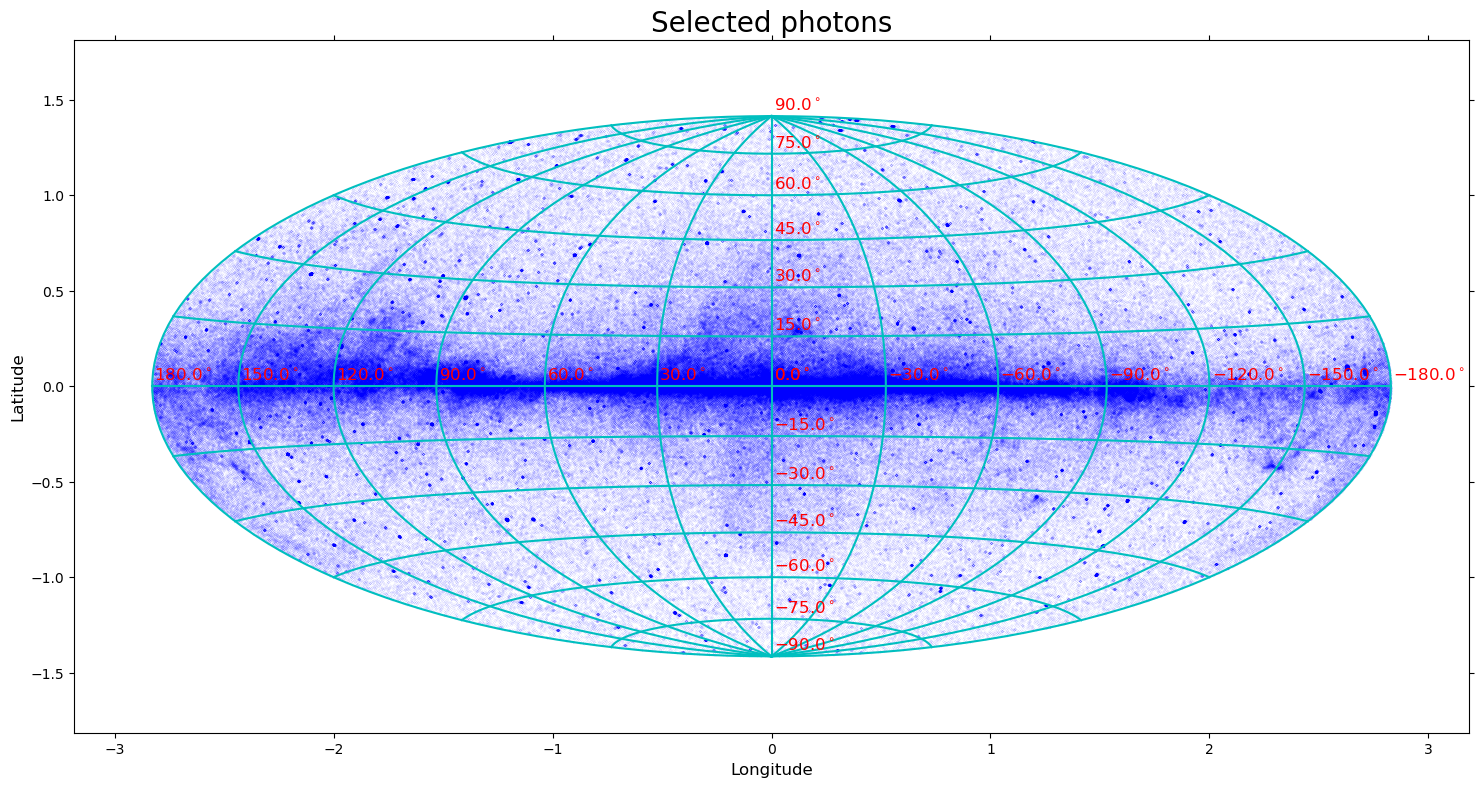

 
Date and time 2024-03-15 14:15:33.411138
Time since last check is 0:00:01.978551


In [5]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
print("Number of photons",nPhotons)
print("RA",RA,"Dec",Dec,"RadRoI",RadRoI)
#
Debug = False
if Debug:
    print(" ")
    print("Running in debug mode! ")
#
eArrPhotons = arrPhotons[:,0]
raArrPhotons = arrPhotons[:,1]
decArrPhotons = arrPhotons[:,2]
#
# Make scatter plot in standard Hammer projection.
fig = plt.figure(figsize=(18, 9))
plt.title('Selected photons', fontsize=20)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
raL, decL = np.zeros(2), np.zeros(2)
raL[0], raL[1] = -180, 180
decL[0], decL[1] = -90, 90
revx = True
fr.hamscat(raArrPhotons, decArrPhotons, 0.001, 'b', revx)
fr.hamscale(raL, decL, "r", revx)
xL, yL = fr.hamlim(raL, decL)
plt.xlim(xL[0], xL[1])
plt.ylim(yL[0], yL[1])
plt.savefig("SelectedPhotons.png")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot and fit the energy spectrum

Plot and fit spectrum of all photons. Use scipy.optimize leastsq routine. Try "log parabola" functional form:
$$
f(E) = N_0\frac{E}{E_b}^{-(\alpha + \beta\log(E/E_b))}.
$$
Here:  
p[0] = $N_0$,  
p[1] = $E_b$.  
p[2] = $\alpha$,  
p[3] = $\beta$.    
Note: $E_b$ (p[1]) is a scale parameter that should be set near the lower energy range of the spectrum being fitted and is usually fixed (Massaro et al., A&A (2004) 413, 489).

Differential required for calculating cost function if want to include $x$ errors is:
$$
\frac{{\partial f}}{{\partial E}} = \frac{{{N_0}}}{E}\left( {\alpha  + 2\beta \log \left[ {\frac{E}{{{E_b}}}} \right]} \right){\left( {\frac{E}{{{E_b}}}} \right)^{ - \left( {\alpha  + \beta \log \left[ {\frac{E}{{{E_b}}}} \right]} \right)}}.
$$
Alternatively, try "broken power law":

$$ 
f(E) = N_0 \times  \begin{array}{ll} (E/E_b)^{\gamma_1} & \mbox{if $E < E_b$}\\ (E/E_b)^{\gamma_2} & \mbox{otherwise.} \end{array}
$$

Differential required for calculating cost function if want to include $x$ errors is:
$$
\frac{{\partial f}}{{\partial E}} = \frac{{\gamma {N_0}}}{{{E_b}}}{\left( {\frac{E}{{{E_b}}}} \right)^{\gamma  - 1}}.
$$

Here  
p[0] = $N_0$  
p[1] = $E_b$  
p[2] = $\gamma_1$  
p[3] = $\gamma_2$  

Date and time 2024-03-15 14:16:13.329100
 
Log parabola with N0 = 1.000, alpha = 2.500, beta = 0.000, normalisation 78099.945
 
Total number of photons 1101865.0
'Nozeros' flag is False
Fit quality: chi**2 = 11.374333721607861 chisq/NDF = 0.33453922710611356
 
Fit results: 
N0 = 13.155432078088095 +/- 0.2863605689848163
alpha = 2.583042666859294 +/- 0.019309000858196486
beta = 0.005553093676569427 +/- 0.010559942361878624


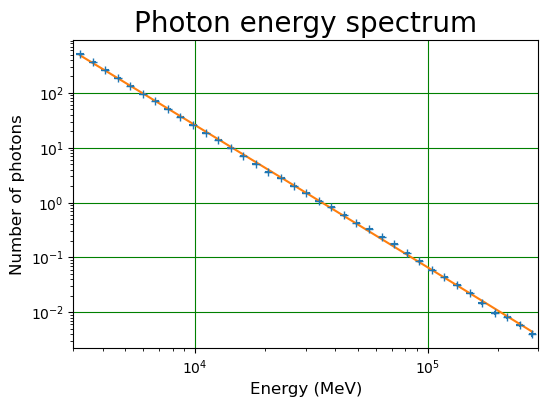

 
Date and time 2024-03-15 14:16:13.853997
Time since last check is 0:00:00.524897


In [8]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
from scipy.optimize import leastsq
from scipy.integrate import quad
#
Debug = False
if Debug:
    print(" ")
    print("Running in debug mode! ")
    print("Looking at source",SourceName)
#
noZeros = False
Eb = 13000
def fE(E, N0, alpha, beta):
    '''
    Return relative frequency given energy and fit parameters for log parabola
    '''
    f = N0*(E/Eb)**(-alpha - beta*np.log(E/Eb))
    return f
# 
N0 = 1.0
alpha = 2.5
beta = 0.0
Int = quad(fE, Emin, Emax, args = (N0, alpha, beta))
Norm = Int[0]
print(" ")
print("Log parabola with N0 = {:.3f}, alpha = {:.3f}, beta = {:.3f}, normalisation {:.3f}".\
       format(N0, alpha, beta,Norm))
#
# Define fit and cost functions
# 1) Log parabola
nPar = 3
def fitFunc(p,x):
    '''
    Log parabola fit function
    '''
    f = p[0]*(x/Eb)**(-p[1] - p[2]*np.log(x/Eb))
    return f
def errFunc(p,x,y,xerr,yerr):
    '''
    Log parabola cost function
    '''
    df = p[0]/x*(p[1] + 2*p[2]*np.log(x/Eb))*(x/Eb)**(-p[1] - p[2]*np.log(x/Eb))
    e = (y - fitFunc(p, x))/np.sqrt(df**2*xerr**2 + yerr**2)
#    e = (y - fitFunc(p, x))/np.sqrt(yerr**2)
    return e
#
Ledges = np.linspace(np.log(Emin),np.log(Emax),nEbins + 1)
edges = np.exp(Ledges)
fig = plt.figure(figsize=(6, 4))
plt.yscale('log')
plt.xscale('log')
eArrPhotons = arrPhotons[:,0]
#
# Make histogram
histEphotons, bins = np.histogram(eArrPhotons, edges)
eBcentre = (bins[:-1] + bins[1:])/2.0
eBwidth = bins[1:] - bins[:-1]
eBerr = eBwidth/np.sqrt(12.0)
hTotal = float(np.sum(histEphotons))
#
# set initial values of fit parameters.
pInit = [hTotal/Norm, alpha, beta]
#
# Correct histogram (for bin widths and treatment of bins with no entries)
if noZeros:
    noZ = np.nonzero(histEphotons)
    nNoZ = np.size(noZ)
    eBcenNoZ = eBcentre[noZ]
    eBwidNoZ = eBwidth[noZ]
    eBerrNoZ = eBerr[noZ]
    hcorrEphotons = histEphotons[noZ]/eBwidNoZ
    hcorrErr = np.sqrt(hcorrEphotons/eBwidNoZ)
else:
    hcorrEphotons = histEphotons/eBwidth
    hcorrErr = np.sqrt(fitFunc(pInit, eBcentre)/eBwidth)
#
# Run "least squares" fit
if noZeros:
    out = leastsq(errFunc, pInit, args=(eBcenNoZ, hcorrEphotons, eBerrNoZ, hcorrErr), full_output=1)
else:
    out = leastsq(errFunc, pInit, args=(eBcentre, hcorrEphotons, eBerr, hcorrErr), full_output=1)   
#
# get output
pFinal = out[0]
covar = out[1]
pGlobal = pFinal
cGlobal = covar
#
# Calculate chi^2 from these fit parameters 
if noZeros:
    chiSqArr = errFunc(pFinal, eBcenNoZ, hcorrEphotons, eBerrNoZ, hcorrErr)**2
else:
    chiSqArr = errFunc(pFinal, eBcentre, hcorrEphotons, eBerr, hcorrErr)**2
#
chiSq = np.sum(chiSqArr)
if noZeros:
    NDF = nNoZ - nPar
else:
    NDF = nEbins - nPar
redChiSq = chiSq/NDF
#
print(" ")
print("Total number of photons",hTotal)
print("'Nozeros' flag is",noZeros)
print("Fit quality: chi**2 =",chiSq,"chisq/NDF =",redChiSq)
#print("chi**2 per point = ",chiSqArr)
print(" ")
print("Fit results: ")
if (covar is None):
    print("Covariance not determined.")
    print("N0 =",pFinal[0])
    print("alpha =",pFinal[1])
    print("beta =",pFinal[2])
else:
    print("N0 =",pFinal[0],"+/-",np.sqrt(covar[0,0]))
    print("alpha =",pFinal[1],"+/-",np.sqrt(covar[1,1]))
    print("beta =",pFinal[2],"+/-",np.sqrt(covar[2,2]))
#
plt.title('Photon energy spectrum', fontsize=20)
plt.xlabel('Energy (MeV)', fontsize=12)
plt.ylabel('Number of photons', fontsize=12)
plt.errorbar(eBcentre, hcorrEphotons, xerr = eBerr, yerr = hcorrErr, fmt = "+")
plt.plot(eBcentre,fitFunc(pFinal, eBcentre))
plt.xlim(Emin, Emax)
plt.grid(color = 'g')
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot photon energies in 2D histogram

Date and time 2024-03-15 14:16:20.084792


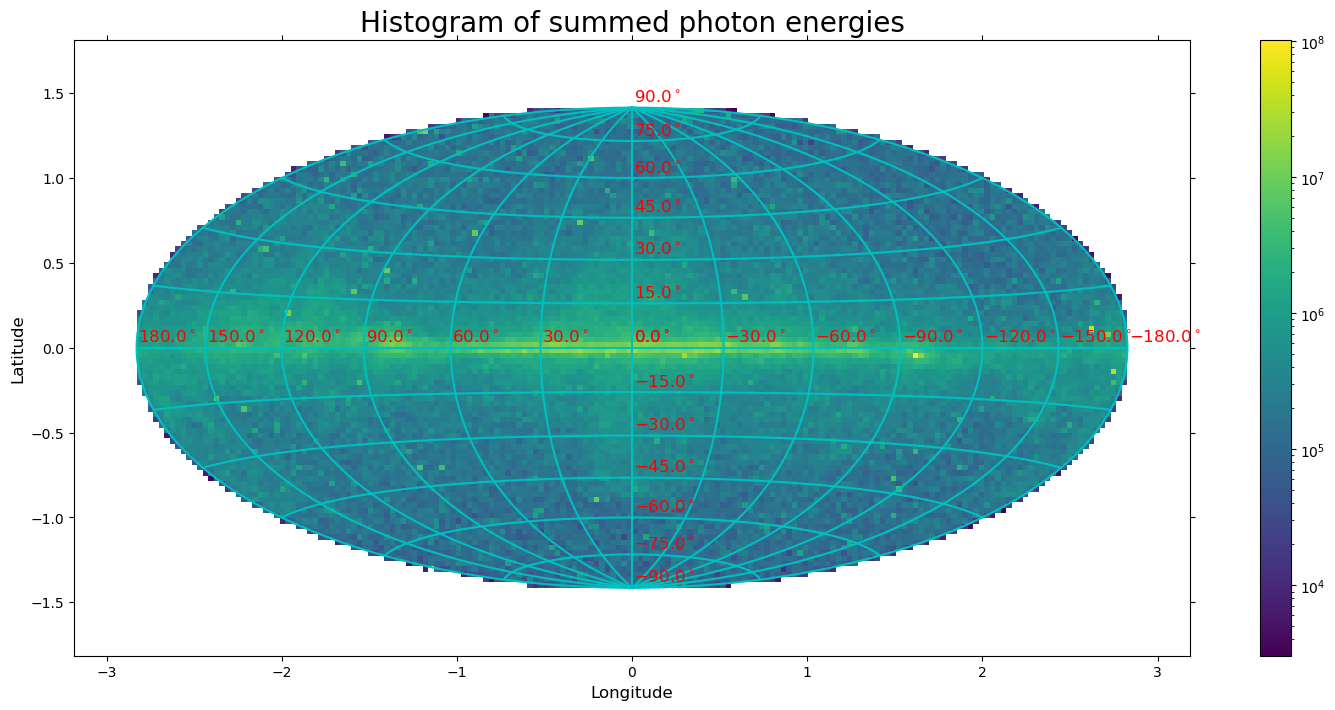

 
Date and time 2024-03-15 14:16:20.800055
Time since last check is 0:00:00.715263


In [9]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
#
Debug = False
if Debug:
    print(" ")
    print("Running in debug mode! ")
#
fig = plt.figure(figsize=(18, 8))
plt.title('Histogram of summed photon energies', fontsize=20)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
raL, decL = np.zeros(2), np.zeros(2)
raL[0], raL[1] = -180, 180
decL[0], decL[1] = -90, 90
revx = True
fr.hamhist2D(raArrPhotons, decArrPhotons, (180, 90), eArrPhotons, revx)
plt.colorbar()
fr.hamscale(raL, decL, "r", revx)
xL, yL = fr.hamlim(raL, decL)
plt.xlim(xL[0], xL[1])
plt.ylim(yL[0], yL[1])
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Get Fermi catalogue information

In [10]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
import pandas as pd
#
names = ["nameSources",
         "alphaSources",
         "deltaSources",
         "spectType",
         "pivotEnergy",
         "PLfluxDensity",
         "errPLfluxDensity",
         "PLindex",
         "errPLindex",
         "LPfluxDensity",
         "errLPfluxDensity",
         "LPindex",
         "errLPindex",
         "LPbeta",
         "errLPbeta",
         "PLECfluxDensity",
         "errPLECfluxDensity",
         "PLECindex",
         "errPLECindex",
         "PLECexpFactor",
         "errPLECexpFactor",
         "PLECexpIndex",
         "errPLECexpIndex",
         "EfluxHundred",
         "errEfluxHundred",
         "EfluxThousand",
         "errEfluxThousand"]
#
catalogue_df = pd.read_csv(OutSourceArray, names = names)
display(catalogue_df)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2024-03-15 14:16:23.924850


nameSources  alphaSources  deltaSources          spectType  \
0     4FGL J0000.3-7355     307.708980    -42.729538  PowerLaw            
1     4FGL J0000.5+0743     101.656480    -53.029457  LogParabola         
2     4FGL J0000.7+2530     108.775070    -35.959175  PowerLaw            
3     4FGL J0001.2+4741     114.250200    -14.338059  PowerLaw            
4     4FGL J0001.2-0747      89.032720    -67.305010  PowerLaw            
...                  ...           ...           ...                ...   
6654  4FGL J2359.3-2049      58.090145    -76.542860  PowerLaw            
6655  4FGL J2359.3+1444     104.564710    -46.256252  LogParabola         
6656  4FGL J2359.7-5041     322.128050    -64.472755  LogParabola         
6657  4FGL J2359.9-3736     345.662840    -74.919624  PowerLaw            
6658  4FGL J2359.9+3145     110.321010    -29.848010  LogParabola         

      pivotEnergy  PLfluxDensity  errPLfluxDensity   PLindex  errPLindex  \
0       2329.5903   2.610434e-14      4.429607e-15  2.179690    0.135742   
1       1304.1947   1.039931e-13      2.185767e-14  2.349694    0.140494   
2       6318.9400   2.058057e-15      6.494554e-16  1.852803    0.211903   
3       2420.5752   2.156031e-14      4.906863e-15  2.271696    0.179057   
4       1721.6039   2.656894e-13      1.741041e-14  2.116692    0.049792   
...           ...            ...               ...       ...         ...   
6654    2594.2498   5.196033e-14      5.244068e-15  1.984188    0.078500   
6655     622.3903   8.512277e-13      1.290912e-13  2.595140    0.112935   
6656     842.0542   1.846089e-13      4.247069e-14  2.684101    0.160861   
6657    1730.6754   6.743669e-14      9.122463e-15  2.120210    0.099106   
6658    3161.0903   2.109173e-14      3.204981e-15  1.883783    0.103562   

      LPfluxDensity  ...  PLECindex  errPLECindex  PLECexpFactor  \
0      2.904301e-14  ...   1.993013      0.237311       0.150609   
1      1.575568e-13  ...   1.998095      0.310854       0.586220   
2      3.043761e-15  ...   1.507830      0.514213       0.720244   
3      2.196550e-14  ...   2.219642      0.229325       0.029462   
4      2.842831e-13  ...   2.046604      0.070298       0.063212   
...             ...  ...        ...           ...            ...   
6654   5.197384e-14  ...   1.934859      0.103371       0.026185   
6655   1.120552e-12  ...   2.248835      0.269181       0.490786   
6656   3.137423e-13  ...   2.448101      0.370554       1.196060   
6657   8.021262e-14  ...   1.994491      0.145641       0.104679   
6658   2.556651e-14  ...   1.597180      0.216451       0.212592   

      errPLECexpFactor  PLECexpIndex  errPLECexpIndex  EfluxHundred  \
0             0.157339      0.666667              NaN  1.581099e-12   
1             0.402050      0.666667              NaN  1.121896e-12   
2             0.682527      0.666667              NaN  8.571274e-13   
3             0.091426      0.666667              NaN  1.499454e-12   
4             0.042852      0.666667              NaN  8.339171e-12   
...                ...           ...              ...           ...   
6654          0.035541      0.666667              NaN  3.883922e-12   
6655          0.310822      0.666667              NaN  2.017364e-12   
6656          0.856958      0.666667              NaN  8.187322e-13   
6657          0.098976      0.666667              NaN  2.139277e-12   
6658          0.144651      0.666667              NaN  1.855474e-12   

      errEfluxHundred  EfluxThousand  errEfluxThousand  
0        2.811228e-13   1.392216e-10      2.362096e-11  
1        3.292749e-13   1.951913e-10      4.085454e-11  
2        2.713094e-13   7.202151e-11      2.553710e-11  
3        3.968492e-13   1.259796e-10      2.877197e-11  
4        5.499454e-13   7.471219e-10      5.041939e-11  
...               ...            ...               ...  
6654     3.999699e-13   3.462985e-10      3.494565e-11  
6655     5.023651e-13   1.796826e-10      3.554968e-11  
6656     2.77201

 
Date and time 2024-03-15 14:16:24.006650
Time since last check is 0:00:00.081800


## Plot positions of identified Fermi sources

Date and time 2024-03-15 14:16:27.390471
 
RoI RA 0.0 Dec 0.0 radius 180.0
Number of sources in RoI 6659 print information about 25 of these.
Source	name			alpha		delta		EfluxHundred	EfluxThousand
1	4FGL J0000.3-7355 	307.709		-42.730		1.581e-12	1.392e-10
2	4FGL J0000.5+0743 	101.656		-53.029		1.122e-12	1.952e-10
3	4FGL J0000.7+2530 	108.775		-35.959		8.571e-13	7.202e-11
4	4FGL J0001.2+4741 	114.250		-14.338		1.499e-12	1.260e-10
5	4FGL J0001.2-0747 	89.033		-67.305		8.339e-12	7.471e-10
6	4FGL J0001.4-0010 	96.892		-60.491		1.231e-12	1.082e-10
7	4FGL J0001.5+2113 	107.649		-40.168		2.556e-11	1.347e-09
8	4FGL J0001.6+3503 	111.538		-26.710		9.720e-13	2.079e-10
9	4FGL J0001.6-4156 	334.226		-72.029		3.560e-12	2.822e-10
10	4FGL J0001.8-2153 	55.185		-77.573		1.061e-12	9.048e-11
11	4FGL J0002.1-6728 	310.085		-48.963		2.390e-12	2.589e-10
12	4FGL J0002.1+6721c	118.203		4.939		6.183e-12	6.264e-10
13	4FGL J0002.3-0815 	89.043		-67.848		1.325e-12	1.191e-10
14	4FGL J0002.4-5156 	319.999		-63.539

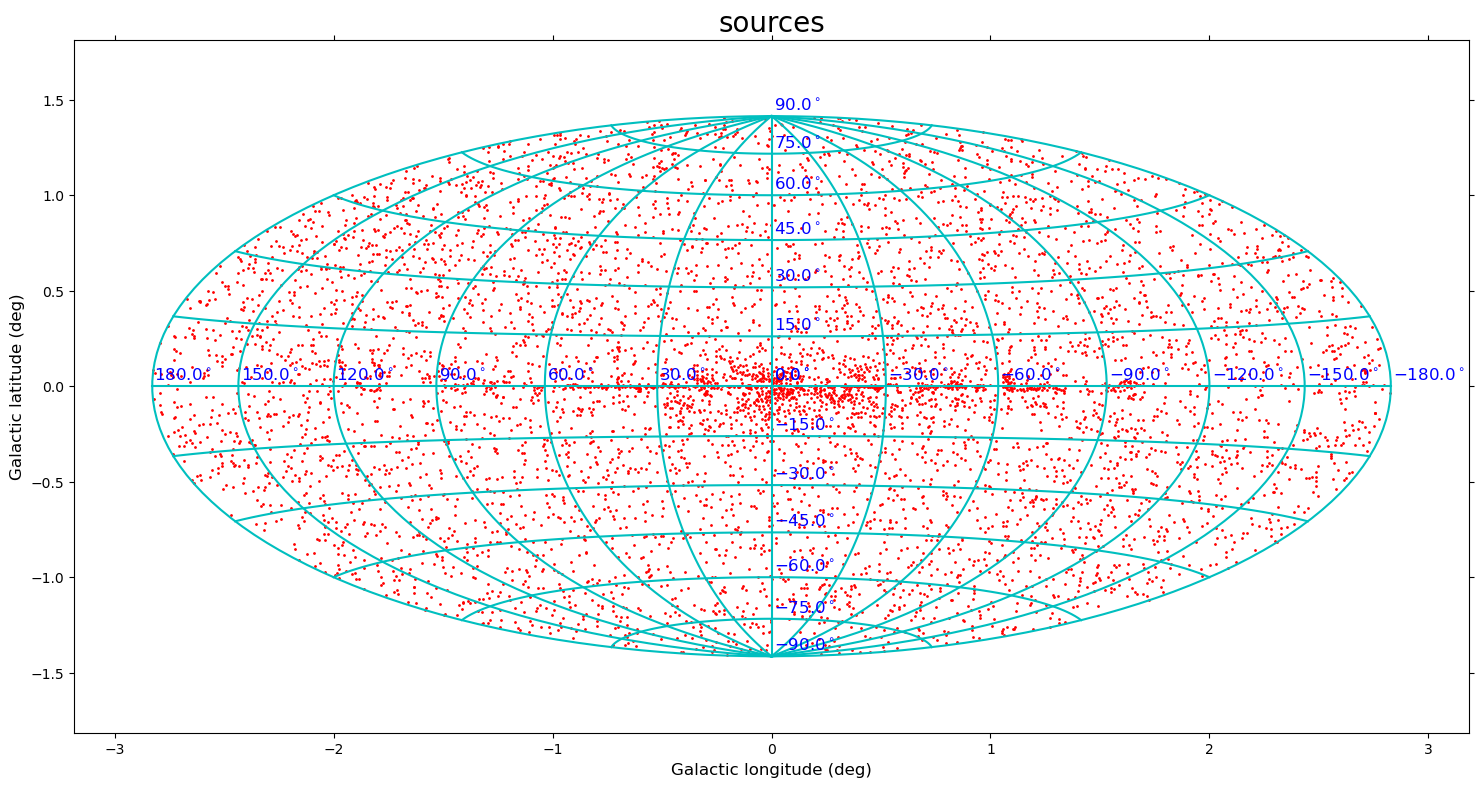

 
Date and time 2024-03-15 14:16:27.697996
Time since last check is 0:00:00.307525


In [11]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
nSources = len(catalogue_df)
#
nameSources = catalogue_df["nameSources"].to_numpy()
alphaSources = catalogue_df["alphaSources"].to_numpy()
deltaSources = catalogue_df["deltaSources"].to_numpy()
spectType = catalogue_df["spectType"].to_numpy()
pivotEnergy = catalogue_df["pivotEnergy"].to_numpy()
PLfluxDensity = catalogue_df["PLfluxDensity"].to_numpy()
errPLfluxDensity = catalogue_df["errPLfluxDensity"].to_numpy()
PLindex = catalogue_df["PLindex"].to_numpy()
errPLindex = catalogue_df["errPLindex"].to_numpy()
LPfluxDensity = catalogue_df["LPfluxDensity"].to_numpy()
errLPfluxDensity = catalogue_df["errLPfluxDensity"].to_numpy()
LPindex = catalogue_df["LPindex"].to_numpy()
errLPindex = catalogue_df["errLPindex"].to_numpy()
LPbeta = catalogue_df["LPbeta"].to_numpy()
errLPbeta = catalogue_df["errLPbeta"].to_numpy()
PLECfluxDensity = catalogue_df["PLECfluxDensity"].to_numpy()
errPLECfluxDensity = catalogue_df["errPLECfluxDensity"].to_numpy()
PLECindex = catalogue_df["PLECindex"].to_numpy()
errPLECindex = catalogue_df["errPLECindex"].to_numpy()
PLECexpIndex = catalogue_df["PLECexpIndex"].to_numpy()
errPLECexpIndex = catalogue_df["errPLECexpIndex"].to_numpy()
EfluxHundred = catalogue_df["EfluxHundred"].to_numpy()
errEfluxHundred = catalogue_df["errEfluxHundred"].to_numpy()
EfluxThousand = catalogue_df["EfluxThousand"].to_numpy()
errEfluxThousand = catalogue_df["errEfluxThousand"].to_numpy()
#
maxPrint = 25
print(" ")
print("RoI RA",RA,"Dec",Dec,"radius",RadRoI)
print("Number of sources in RoI",nSources,"print information about",maxPrint,"of these.")
print("Source\tname\t\t\talpha\t\tdelta\t\tEfluxHundred\tEfluxThousand")
for i in range(0,max(10,maxPrint)):
    print("{:1d}\t{:18s}\t{:.3f}\t\t{:.3f}\t\t{:.3e}\t{:.3e}".\
    format(i + 1, nameSources[i], alphaSources[i], deltaSources[i], EfluxHundred[i], EfluxThousand[i]))
print(" ")
print("Source\tname\t\t\ttype\t\t pivotEnergy\tLPfluxDensity\tLPindex\t\tLPbeta")
for i in range(0,max(10,maxPrint)):
    print("{:1d}\t{:18s}\t{:.18s}{:.3f}\t{:.1e}\t\t{:.1e}\t\t{:.1e}".\
    format(i + 1, nameSources[i], spectType[i], pivotEnergy[i], LPfluxDensity[i], LPindex[i], \
          LPbeta[i]))
#
print(" ")
fig = plt.figure(figsize=(18, 9))
plt.title('sources', fontsize=20)
plt.xlabel('Galactic longitude (deg)', fontsize=12)
plt.ylabel('Galactic latitude (deg)', fontsize=12)
raL, decL = np.zeros(2), np.zeros(2)
raL[0], raL[1] = -180, 180
decL[0], decL[1] = -90, 90
revx = True
fr.hamscat(alphaSources, deltaSources, 1, 'r', revx)
fr.hamscale(raL, decL, "b", revx)
xL, yL = fr.hamlim(raL, decL)
plt.xlim(xL[0], xL[1])
plt.ylim(yL[0], yL[1])
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))